<a href="https://colab.research.google.com/github/emiliehp/DAT300/blob/emilie/ca1_dat300_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compulsory Assignment 1: Dense neural networks - Implementing an ANN with Keras

Please fill out the the group name, number, members and optionally the group name below.

**Group number 19**: \
**Group member 1**: Anne Berit \
**Group member 2**: Benjamin \
**Group member 3**: Emilie


# Assignment submission

To complete this assignment, answer the all the questions in this notebook and write the code required to implement different models. **Submit the assignment by handing in this notebook as both an .ipynb file and a .pdf file**.

Here are some do’s and don’ts for the submission:

- Read questions thoroughly before answering.
- Make sure to answer all questions.
- Ensure all code cells are run.
- Label all axes in plots.
- Ensure all figures are visible in the PDF.
- Provide a brief explanation of how your code works

# Introduction

In this assignment we will work with the task of classifying hand gestures from the Sign Language MNIST dataset. This time you will implement the network using the Keras API of the TensorFlow library. TensorFlow and PyTorch are both free open-source software libraries intended to simplify multiplication of tensors, but are mostly used for the design and implementation of deep neural networks. Both libraries simplify the implementation of neural networks, and allow for faster training of networks by utlizing hardware acceleration with Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs)

TensorFlow was developed by Google Brain for internal use in Google and was initially released under Apache 2.0 License in 2015 [1](https://en.wikipedia.org/wiki/TensorFlow). Keras was initially released as separate software library, developed by François Chollet, to simplify the Python interface for design of artificial neural networks. Up until version 2.3 Keras supported multiple backend libraries including TensorFlow, Microsoft Cognitive Toolkit, Theano, and PlaidML [2](https://en.wikipedia.org/wiki/Keras). When TensorFlow 2.0 was released in 2019, keras was included as a TensorFlow specific API that is accessible by:

```python
import tensorflow.keras as ks
```
PyTorch was originally developed by Meta AI (formerly known as Facebook) in 2016, but is now under umbrella of the Linux foundation, and is open-source under the BSD license [3](https://en.wikipedia.org/wiki/PyTorch). While TensorFlow was the most popular framework for a long time, PyTorch has been gaining more and more users in the last five years and is now more used in industry and is becoming more popular in research as well.

The lectures of DAT300 will be taught using the Keras API in TensorFlow, and we recommend you to stick with Keras and TensorFlow for this course as it is easier for beginners to get started with.

# Dataset descirption
The Sign Language MNIST dataset is a collection of grayscale images of size 28×28 pixels, representing hand gestures for the letters A–Y in American Sign Language (ASL). The letters J and Z are excluded since they involve motion.

*   Training set: 27,455 images

*   Test set: 7,172 images

*   Number of classes: 24 (letters A–Y, excluding J and Z)

*   Format: Each image is stored as a flattened vector of 784 pixels, with an accompanying label indicating the class (0–23).

This dataset is commonly used as a benchmark for image classification tasks, similar to the original MNIST handwritten digits dataset, but adapted for sign language recognition.

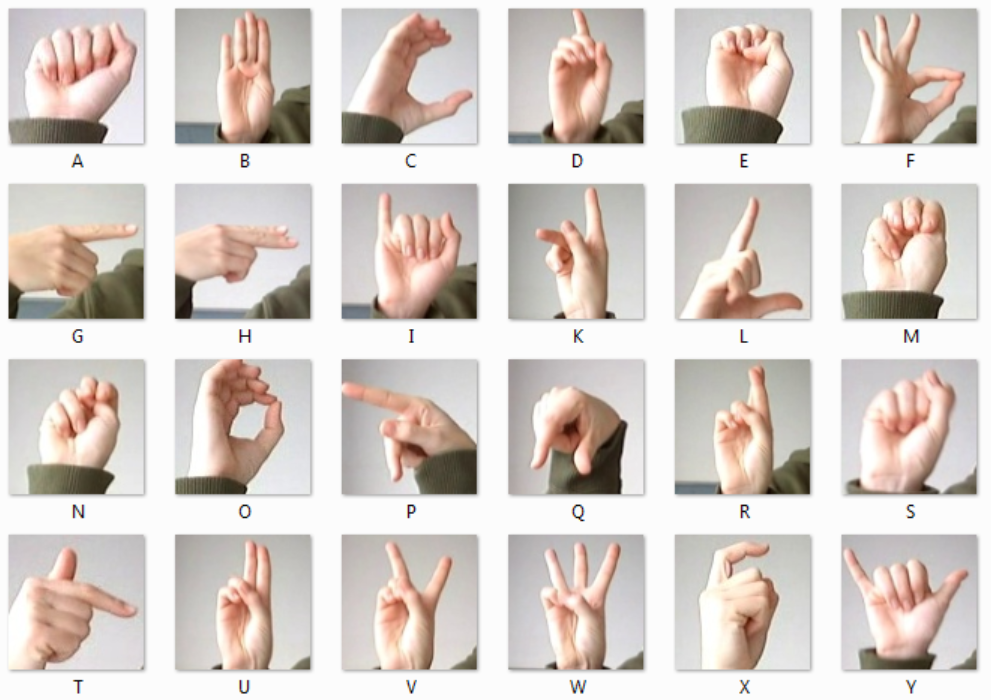

# Assignment structure

1. Part 1: Import, preprocess, and visualize the data.
2. Part 2: Design your own Dense Neural Network (NN) architecture for classifying MNIST in Keras.
3. Part 3: Train one of the Machine Learning classifiers that you learned about in DAT200.
4. Part 4: Compare and discuss the results.

## Supporting code

You may find the code below useful for plotting the metrics and calculating the F1-score for your model in Part 2.



In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf

"""
A function that plots the training and validation metrics over epochs
"""
def plot_training_history(training_history_object, list_of_metrics=None):

    """
    training_history_object: Object returned by model.fit() function in keras
    list_of_metrics: A list of MAX two metrics to be plotted
    """
    history_dict = training_history_object.history
    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]

    trainHistDF = pd.DataFrame(history_dict)
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout
    plt.show()

"""
Custom Keras callback for computing the F1-score after each epoch.
This callback calculates both training and validation F1-scores
"""
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val

    def on_epoch_end(self, epoch, logs=None):
        # Training F1
        y_train_pred = self.model.predict(self.X_train, verbose=0).argmax(axis=1)
        f1_train = f1_score(self.y_train, y_train_pred, average="macro")

        # Validation F1
        y_val_pred = self.model.predict(self.X_val, verbose=0).argmax(axis=1)
        f1_val = f1_score(self.y_val, y_val_pred, average="macro")

        logs["f1"] = f1_train
        logs["val_f1"] = f1_val
        print(f" — f1: {f1_train:.4f} — val_f1: {f1_val:.4f}")


## Library imports

In [59]:
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Task 1: Importing, preprocess and visualizing the data

In this assignment you yourselves will be responsible for the data-preprocessing. Use the cells below for preprocessing and visualization, and optionally some exploration of the dataset if you feel inclined.

## Importing data
You will need to upload both CSV files from the zip folder to Google Colab and run the code sell below to load the data.

In [60]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -o "/content/drive/MyDrive/DAT300/CA1_DAT300.zip" -d project
!ls project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/DAT300/CA1_DAT300.zip
  inflating: project/ca1_dat300_2025.ipynb  
  inflating: project/sign_mnist_test.csv  
  inflating: project/sign_mnist_train.csv  
ca1_dat300_2025.ipynb  sign_mnist_test.csv  sign_mnist_train.csv


In [61]:
# Sign language MNIST

# Load the data
train = pd.read_csv("project/sign_mnist_train.csv")
test = pd.read_csv("project/sign_mnist_test.csv")

# Split data into features and lables
X_train = train.drop(columns=['label']).to_numpy(dtype=np.float32)
y_train = train['label'].to_numpy(dtype=np.int32)
X_test  = test.drop(columns=['label']).to_numpy(dtype=np.float32)
y_test  = test['label'].to_numpy(dtype=np.int32)

## Task 1.1 Preprocessing
Preprocess the data in whatever way you find sensible. Remember to comment on what you do.

In [62]:
# Check shape
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Normalize the data
X_train_norm = X_train / 255.0
X_test_norm  = X_test / 255.0

# Fix labels and removing empty class '9'
y_train_fixed = np.array([label if label < 9 else label - 1 for label in y_train])
y_test_fixed  = np.array([label if label < 9 else label - 1 for label in y_test])

# Check the unique labels
print(np.unique(y_train_fixed))
print(np.unique(y_test_fixed))



(27455, 784) (27455,)
(7172, 784) (7172,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Task 1.2 Visualization
Visualize the data in whatever manner you find helpful/sensible and briefly comment on the plots.

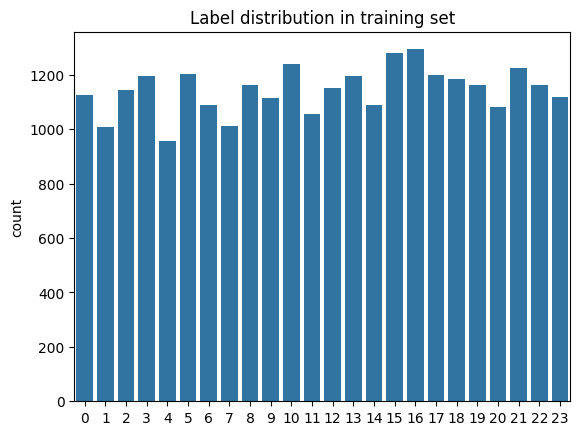

In [63]:
# Check visialization of distribution of classes
sns.countplot(x=y_train_fixed)
plt.title("Label distribution in training set")
plt.show()



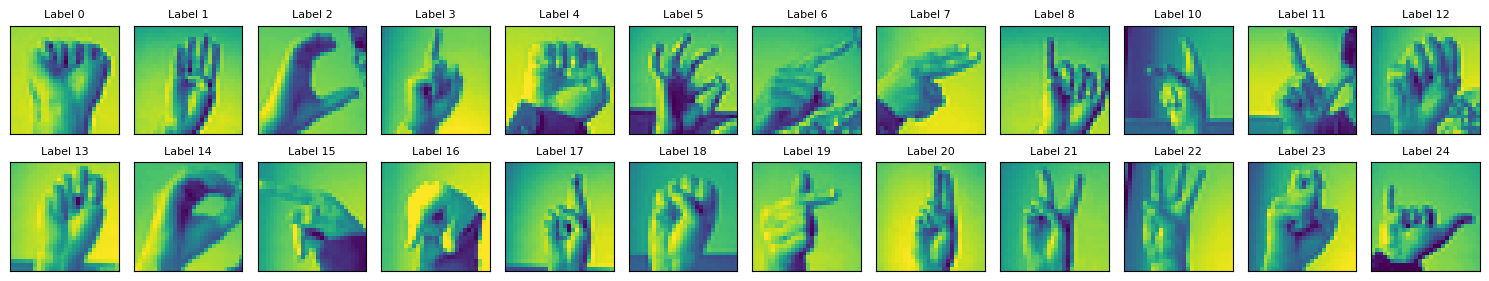

In [64]:
# Visualize one example of each class
fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(15, 3), sharex=True, sharey=True)
ax = ax.flatten()

for i, label in enumerate(sorted(np.unique(y_train))):
    img = X_train[y_train == label][0].reshape(28, 28)
    ax[i].imshow(img, cmap='viridis')
    ax[i].set_title(f"Label {label}", fontsize=8)
    ax[i].set_xticks([]); ax[i].set_yticks([])

plt.tight_layout()
plt.show()

# Task 2: Design your own ANN architecture
In this task you are free to design the network architecture for the MNIST Gesture recognition challenge with a couple of stipulations:
* use **only Dense or fully connected layers**,
* use both **accuracy and the F1-score** as performance metrics.

Otherwise, you are free to use whatever loss-function, optimizer and activation functions you want and train it for as many epochs you want.

## Task 2.1: Implement your own network architecture
Design your network below:

(Feel free to add as many code and markdown cells as you want)

In [65]:

# Defining number of classes
num_classes = len(np.unique(y_train_fixed))

# Building the model
model = models.Sequential([
layers.Input(shape=(784,)),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(num_classes, activation='softmax')
])

#Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,296 (430.84 KB)

 Trainable params: 110,296 (430.84 KB)

 Non-trainable params: 0 (0.00 B)

## Task 2.2: Train your network and visualize the training history
Train the model and plot the training history in the code cell(s) below. Feel free to use the function `plot_training_history()` and the custom Keras callback `F1ScoreCallback()` from Supporting code section.

Epoch 1/10
 — f1: 0.4417 — val_f1: 0.4358
611/611 - 6s - 11ms/step - accuracy: 0.2795 - loss: 2.3403 - val_accuracy: 0.4573 - val_loss: 1.7144 - f1: 0.4417 - val_f1: 0.4358
Epoch 2/10
 — f1: 0.6475 — val_f1: 0.6392
611/611 - 7s - 11ms/step - accuracy: 0.5433 - loss: 1.4374 - val_accuracy: 0.6425 - val_loss: 1.1922 - f1: 0.6475 - val_f1: 0.6392
Epoch 3/10
 — f1: 0.6658 — val_f1: 0.6622
611/611 - 6s - 9ms/step - accuracy: 0.6703 - loss: 1.0405 - val_accuracy: 0.6711 - val_loss: 1.0328 - f1: 0.6658 - val_f1: 0.6622
Epoch 4/10
 — f1: 0.7607 — val_f1: 0.7488
611/611 - 7s - 11ms/step - accuracy: 0.7413 - loss: 0.8146 - val_accuracy: 0.7430 - val_loss: 0.7873 - f1: 0.7607 - val_f1: 0.7488
Epoch 5/10
 — f1: 0.8403 — val_f1: 0.8263
611/611 - 5s - 9ms/step - accuracy: 0.8047 - loss: 0.6340 - val_accuracy: 0.8243 - val_loss: 0.5453 - f1: 0.8403 - val_f1: 0.8263
Epoch 6/10
 — f1: 0.8187 — val_f1: 0.8135
611/611 - 6s - 9ms/step - accuracy: 0.8437 - loss: 0.5037 - val_accuracy: 0.8159 - val_loss: 0.

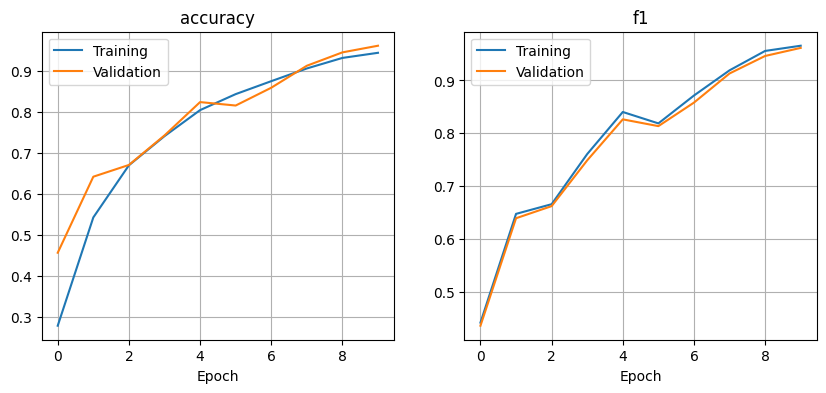

In [66]:
X_full = X_train
y_full = y_train_fixed

# Split the data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train_norm, y_train_fixed, test_size=0.2, random_state=42, stratify=y_train_fixed)

# Train the model with F1-score callback
f1_callback = F1ScoreCallback(X_tr, y_tr, X_val, y_val)

history = model.fit(X_tr, y_tr,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=36,
                    callbacks=[f1_callback],
                    verbose=2)

plot_training_history(history, list_of_metrics=['accuracy', 'f1'])

## Task 2.3: Discuss the results
**Question 2.3.1**: What could happen if the model is too shallow or too deep?

**Question 2.3.2**: How does the choice of train/validation/test split ratio affect the training process and the final performance of a deep learning model?

**Question 2.3.3**: How do accuracy and F1-Score values compare (are they similar or very different from each other)? What does it tell you about the MNIST dataset and which one of these metrics is more reliable in this case?

**Question 2.3.4**: Explain **very briefly** how each of the following model hyperparameters can impact the model's performance:
- Number of layers
- Number of neurons in a layer
- Batch size
- Optimizers
- Regularization techniques (such as L2 regularization).

  **Answer 2.3.1:** If the model is too shallow it can lead to underfitting, and if it is too deep it can lead to overfitting.

  **Answer 2.3.2:** If the training set is too small, it will not train generally enough. If the validation set is too small, it will not represent the overall dataset, making it difficult to choose appropriate hyperparameters. The same applies to the test set. If it is too small, it will not reflect the whole dataset.

  **Answer 2.3.3:** Accuracy measures the proportion of correct predictions in the dataset. However, this will not be a good measure if the data is unbalanced based on the target. The F1 score considers both precision and recall, giving a better reflection of performance in such cases. If accuracy and F1 score differ significantly, it is likely that the dataset is imbalanced. In these situations, the F1 score is a more robust measure.

  **Answer 2.3.4**:
- Number of layers: A high numer of layers allows the model to capture more complex features, but also raises the risk of overfitting and requires more computation.
- Number of neurons in a layer: More neurons increase the models capacity to learn more coplex data, but also increase the risk of overfitting and computational cost.
- Batch size: Small batches introduce more noise in gradient estimates, which can improve generalization but slow convergence. Large batches speed up training but may reduce generalization.
- Optimizers: Determines how the weights are updated, affecting speed of convergence and stability.
- Regularization techniques (such as L2 regularization): Reduces overfitting by limiting wheights or force the model to learn more generalized patterns.

# Task 3: Design and train a classical machine learning classifier
Pick your **favourite** machine learning classifer that you learned about in DAT200 and train it for the MNIST gesture recognition problem. (Hint: use the scikit-learn library). Remember to use **accuracy and the F1-score** as performance metrics.

In [67]:

# Split the data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Initializing Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf.fit(X_tr, y_tr)

# Predictions
y_val_pred = rf.predict(X_val)


# Evaluate
val_acc = accuracy_score(y_val, y_val_pred)
val_f1  = f1_score(y_val, y_val_pred, average='macro')



print(f"Validation Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")

Validation Accuracy: 0.9982, F1-score: 0.9982


# Task 4: Compare and discuss
Evaluate the ANN model you implemented in Task 2 against the classical machine learning model from Task 3, using the test dataset. Compare the two models based on:

* Accuracies and F1-scores they attain
* Time it takes to train them

Did you experience any trouble when training models in tasks 2 and 3?

In [68]:
test_loss, test_acc = model.evaluate(X_test_norm, y_test_fixed) # Removed one-hot encoding
print(f"Test accuracy: {test_acc:.4f}")

# Get predicted probabilities for each class
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Compute F1 score
f1 = f1_score(y_test_fixed, y_pred, average="macro")
print(f"Test F1-score: {f1:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7026 - loss: 1.0798
Test accuracy: 0.7087
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test F1-score: 0.6698


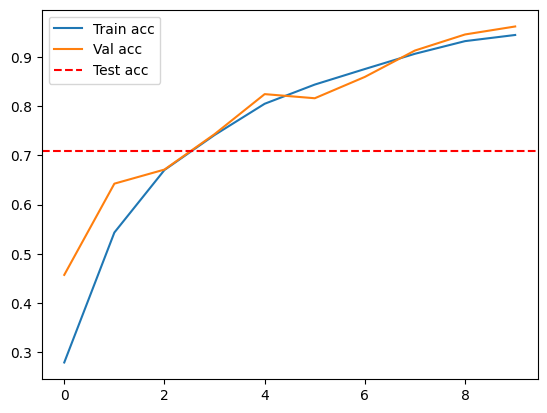

In [69]:
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.axhline(y=test_acc, color="r", linestyle="--", label="Test acc")
plt.legend()
plt.show()

In [70]:
# Get probabilities from the rf model for each class, and compute accuracy score and F1 score
y_test_pred_rain = rf.predict(X_test)
test_acc_rain = accuracy_score(y_test, y_test_pred_rain)
test_f1  = f1_score(y_test, y_test_pred_rain, average='macro')


print(f"Test Accuracy:  {test_acc_rain:.4f}, F1-score: {test_f1:.4f}")

Test Accuracy:  0.8182, F1-score: 0.8029


**Task 4 discussion Here:**



Generally the Random Forest model is better than the model created in task 2. Both the accuracy and the F1-score is better, and less time consuming than the model craeted in task 2.